In [1]:
import tensorflow as tf
import numpy as np

# 1. Dados ────────────────────────────────────────────────────────────────
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0          # normaliza
x_train = x_train[..., None].astype("float32")             # (28,28)→(28,28,1)
x_test  = x_test[..., None].astype("float32")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


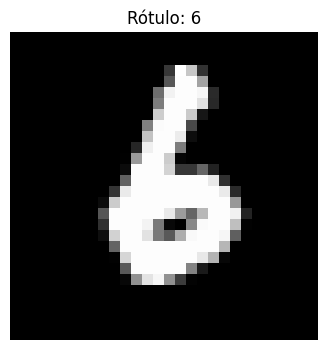

In [5]:
import matplotlib.pyplot as plt
import random

# Supondo que x_train e y_train já existam (já normalizados como float32 e com shape (28,28,1))
# 1. Escolhe um índice aleatório
idx = random.randint(0, x_train.shape[0] - 1)

# 2. Recupera a imagem e o rótulo
img = x_train[idx].squeeze()      # squeeze() transforma (28,28,1) em (28,28)
label = y_train[idx]

# 3. Plota
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title(f"Rótulo: {label}")
plt.axis('off')   # desliga os eixos para ficar mais limpo
plt.show()


# Treino Modelo

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [3]:
model.fit(x_train, y_train,
          epochs=5, batch_size=128,
          validation_split=0.1)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8475 - loss: 0.5190 - val_accuracy: 0.9802 - val_loss: 0.0637
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9805 - loss: 0.0628 - val_accuracy: 0.9863 - val_loss: 0.0469
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9852 - val_loss: 0.0502
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9898 - loss: 0.0328 - val_accuracy: 0.9877 - val_loss: 0.0369
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9921 - loss: 0.0245 - val_accuracy: 0.9883 - val_loss: 0.0398


In [6]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Acurácia de teste: {acc:.4f}")

Acurácia de teste: 0.9899


# Conversão p/ TensorFlow Lite

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)



In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [9]:
tflite_model = converter.convert()
open("mnist_cnn.tflite", "wb").write(tflite_model)
print("Modelo salvo em mnist_cnn.tflite")

Saved artifact at '/tmp/tmpuxhosq_r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140468609548368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609551824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609555280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609553936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609551440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo salvo em mnist_cnn.tflite


In [17]:
# índice da imagem no batch de teste
index = 8

# prepara o sample e recupera o rótulo verdadeiro
sample = x_test[index : index+1]      # shape (1, 28, 28, 1)
true_label = y_test[index]            # rótulo “verdadeiro”

print("Classe verdadeira:", true_label)

# faz inference TFLite
interpreter = tf.lite.Interpreter(model_path="mnist_cnn.tflite")
#interpreter = tf.lite.Interpreter(model_path="mnist_cnn_int8.tflite")

interpreter.allocate_tensors()

input_idx  = interpreter.get_input_details()[0]["index"]
output_idx = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_idx, sample)
interpreter.invoke()
pred = interpreter.get_tensor(output_idx)

print("Dígito previsto:", np.argmax(pred))


Classe verdadeira: 5
Dígito previsto: 5


In [11]:
def rep_data():
    for imgs in tf.data.Dataset.from_tensor_slices(x_train).batch(100).take(100):
        yield [imgs]                       # 10 000 amostras ~ suficiente

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data          # calibragem
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8           # ou int8
converter.inference_output_type = tf.uint8
tflite_quant = converter.convert()
open("mnist_cnn_int8.tflite", "wb").write(tflite_quant)


Saved artifact at '/tmp/tmpqh7b6_06'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140468609548368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609551824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609555280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609553936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609551440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468609554704: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


235600